# Northward Heat Transport

* This notebook uses the `T_ady_2d` diagnostic from MOM6 and compares with observations.<br>
* (Note: For models that use neutral diffusion, this notebook may need futher modification.)
* Author: John Krasting

In [1]:
# For testing and development purposes, enter a start year, end year, and
# an dora id number to analyze. The value of dora_id can also be a direct
# path to a /pp directory.

config = {
    "startyr": None,
    "endyr": None,
    "dora_id": "odiv-411",
}

In [2]:
# Make sure this cell is active so that the workflow and Dora can update
# the config dictionary at runtime.

from gfdlnb.tools.update_notebook_config import update_notebook_config
config = update_notebook_config(config)

In [3]:
print(str(config))

{'startyr': None, 'endyr': None, 'dora_id': 'odiv-411'}


### Import Python Modules

In [4]:
import datetime
import glob
import itertools
import os
import subprocess

import cmip_basins
import doralite

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import momgrid as mg
os.environ["MOMGRID_WEIGHTS_DIR"] = "/nbhome/John.Krasting/grid_weights"

### Definie Local Parameters

In [5]:
#List of all experiments to consider
experiments = [doralite.dora_metadata(x) for x in config["dora_id"].split(",")]

# Define start and end years
start = config["startyr"]
start = int(start) if start is not None else 1

end = config["endyr"]
end = int(end) if end is not None else 9999

### Determine what files to load

In [6]:
def is_in_range(file,start,end):
    """Function determines if a candidate netcdf file is
    within the requested date range"""
    start = int(start)
    end = int(end)
    target = set(list(range(start,end+1)))
    fname = os.path.basename(file)
    times = fname.split(".")[1]
    times = times.split("-")
    times = [int(x[0:4]) for x in times]
    candidate = set(list(range(times[0],times[1]+1)))
    return len(candidate.intersection(target)) > 0

In [7]:
datafiles = []
staticfiles = []

for experiment in experiments:
    _pathPP = experiment["pathPP"]

    # Workaround for different pp structure in OM4
    if experiment["id"] == "odiv-1":
        possible_components = ["ocean_monthly"]
    else:
        possible_components = ["ocean_annual", "ocean_monthly"]

    for component in possible_components:
        static = f"{component}/{component}.static.nc"
        varname = "ann"

        chunk = "5yr"
        filelist = sorted(
            glob.glob(
                f"{_pathPP}{component}/av/annual_{chunk}/{component}.*.{varname}.nc"
            )
        )

        filelist = [x for x in filelist if is_in_range(x, start, end)]
        _staticfile = f"{_pathPP}/{static}"

        if len(filelist) > 0:
            staticfiles.append(_staticfile)
            datafiles.append(filelist) 
            break

    if len(filelist) == 0:
        print(f"No files found, skipping experiment {experiment['expName']}")
        experiments.remove(experiment)

allfiles = sorted(list(itertools.chain(*datafiles)) + staticfiles)
_ = [print(x) for x in allfiles]

/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b05_Roquet_noArcticHenyey/gfdl.ncrc5-intel23-prod/pp//ocean_annual/ocean_annual.static.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b05_Roquet_noArcticHenyey/gfdl.ncrc5-intel23-prod/pp/ocean_annual/av/annual_5yr/ocean_annual.1958-1962.ann.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b05_Roquet_noArcticHenyey/gfdl.ncrc5-intel23-prod/pp/ocean_annual/av/annual_5yr/ocean_annual.1963-1967.ann.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b05_Roquet_noArcticHenyey/gfdl.ncrc5-intel23-prod/pp/ocean_annual/av/annual_5yr/ocean_annual.1968-1972.ann.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b05_Roquet_noArcticHenyey/gfdl.ncrc5-intel23-prod/pp/ocean_annual/av/annual_5yr/ocean_annual.1973-1977.ann.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b05_Roquet_noArcticHenyey/gfdl.ncrc5-intel23-prod/pp/ocean_annual/av/annual_5yr/ocean_annual.1978-1982.ann.nc


In [8]:
# This cell will call `dmget` on the files if run interactively
if not "DORA_EXECUTE" in os.environ.keys():
    print("Calling dmget on files ...")
    cmd = ["dmget"]+allfiles
    _ = subprocess.check_output(cmd)

Calling dmget on files ...


### Calculate the Northward Heat Transport for each experiment

The Atlantic basin northward heat transport is calculated for each candidate
experiment and stored in the `results` list

In [9]:
atl_results = []
pac_results = []
gbl_results = []


for n, exp in enumerate(experiments):
    ds = mg.Gridset(datafiles[n]).data
    var = ds["T_ady_2d"]
    ds = xr.Dataset({var.name: var})
    ds = ds.mean("time")

    # Nominal Latitude for plotting
    lat = ds.geolat_v.mean("xh")

    # Global
    result = ds["T_ady_2d"].sum("xh")
    result = result.assign_coords({"yq": lat.values})
    result = result.rename({"yq": "lat"})

    # Convert to PW
    result = result * 1.e-15 
    gbl_results.append(result.load())

    # Atlantic
    mask = cmip_basins.generate_basin_codes(ds, lon="geolon_v", lat="geolat_v")
    mask = xr.where(
        (mask == 2)
        | (mask == 4)
        | (mask == 6)
        | (mask == 7)
        | (mask == 8)
        | (mask == 9),
        1,
        0,
    )

    result = (ds["T_ady_2d"] * mask).sum("xh")
    result = result.assign_coords({"yq": lat.values})
    result = result.rename({"yq": "lat"})

    # Convert to PW
    result = result * 1.e-15 
    atl_results.append(result.load())

    # Indo-Pacific
    mask = cmip_basins.generate_basin_codes(ds, lon="geolon_v", lat="geolat_v")
    mask = xr.where(
        (mask == 3) | (mask == 5),
        1,
        0,
    )

    result = (ds["T_ady_2d"] * mask).sum("xh")
    result = result.assign_coords({"yq": lat.values})
    result = result.rename({"yq": "lat"})

    # Convert to PW
    result = result * 1.e-15 
    pac_results.append(result.load())

In [10]:
all_stats = []

for n,exp in enumerate(experiments):
    stats = {}
    atl_vals = np.array(atl_results[n].fillna(0.))
    lat_vals = np.array(atl_results[n].lat.fillna(0.))
    max_index = np.unravel_index(np.argmax(atl_vals), atl_vals.shape)
    stats["atlantic"] = {
        "max": round(float(atl_vals[max_index]),2),
        "max_lat": round(float(lat_vals[max_index]),2),
    }

    pac_vals = np.array(pac_results[n].fillna(0.))
    lat_vals = np.array(pac_results[n].lat.fillna(0.))
    max_index = np.unravel_index(np.argmax(pac_vals), pac_vals.shape)
    min_index = np.unravel_index(np.argmin(pac_vals), pac_vals.shape)
    stats["indopac"] = {
        "max": round(float(pac_vals[max_index]),2),
        "max_lat": round(float(lat_vals[max_index]),2),
        "min": round(float(pac_vals[min_index]),2),
        "min_lat": round(float(pac_vals[min_index]),2),
    }
    
    gbl_vals = np.array(gbl_results[n].fillna(0.))
    lat_vals = np.array(gbl_results[n].lat.fillna(0.))
    max_index = np.unravel_index(np.argmax(gbl_vals), gbl_vals.shape)
    min_index = np.unravel_index(np.argmin(gbl_vals), gbl_vals.shape)
    stats["global"] = {
        "max": round(float(gbl_vals[max_index]),2),
        "max_lat": round(float(lat_vals[max_index]),2),
        "min": round(float(gbl_vals[min_index]),2),
        "min_lat": round(float(lat_vals[min_index]),2),
    }
    
    all_stats.append(stats)

### Make a plot with the results

In [11]:
# Trenberth and Caron Obs.
dsobs = xr.open_dataset("/archive/jpk/om4labs/datasets/Trenberth_and_Caron/Trenberth_and_Caron_Heat_Transport.nc")

yobs = dsobs.ylat.values
NCEP_Global = dsobs.OTn.values
NCEP_Atlantic = dsobs.ATLn.values
NCEP_IndoPac = dsobs.INDPACn.values
ECMWF_Global = dsobs.OTe.values
ECMWF_Atlantic = dsobs.ATLe.values
ECMWF_IndoPac = dsobs.INDPACe.values

In [12]:
# Ganachaud, A. and C. Wunsch Obs.

class GWObs:
    class _gw:
        def __init__(self, lat, trans, err):
            self.lat = lat
            self.trans = trans
            self.err = err
            self.minerr = trans - err
            self.maxerr = trans + err

        def annotate(self, ax):
            for n in range(0, len(self.minerr)):
                if n == 0:
                    ax.plot(
                        [self.lat[n], self.lat[n]],
                        [self.minerr[n], self.maxerr[n]],
                        "c",
                        linewidth=2.0,
                        label="G&W",
                    )
                else:
                    ax.plot(
                        [self.lat[n], self.lat[n]],
                        [self.minerr[n], self.maxerr[n]],
                        "c",
                        linewidth=2.0,
                    )
                ax.scatter(self.lat, self.trans, marker="s", facecolor="cyan")

    def __init__(self):
        self.gbl = self._gw(
            np.array([-30.0, -19.0, 24.0, 47.0]),
            np.array([-0.6, -0.8, 1.8, 0.6]),
            np.array([0.3, 0.6, 0.3, 0.1]),
        )
        self.atl = self._gw(
            np.array([-45.0, -30.0, -19.0, -11.0, -4.5, 7.5, 24.0, 47.0]),
            np.array([0.66, 0.35, 0.77, 0.9, 1.0, 1.26, 1.27, 0.6]),
            np.array([0.12, 0.15, 0.2, 0.4, 0.55, 0.31, 0.15, 0.09]),
        )
        self.indpac = self._gw(
            np.array([-30.0, -18.0, 24.0, 47.0]),
            np.array([-0.9, -1.6, 0.52, 0.0]),
            np.array(
                [
                    0.3,
                    0.6,
                    0.2,
                    0.05,
                ]
            ),
        )

GW = GWObs()

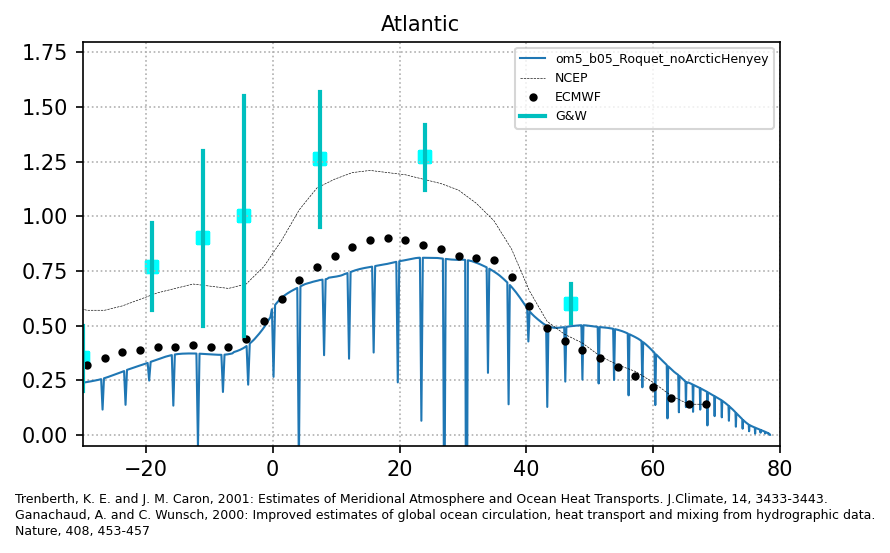

In [13]:
fig = plt.figure(figsize=(6, 3.5), dpi=150)
ax = plt.subplot(1, 1, 1)
for n, exp in enumerate(experiments):
    result = atl_results[n]
    ax.plot(result.lat, result.values, linewidth=1.0, label=exp["expName"])
ax.plot(yobs, NCEP_Atlantic, "k--", linewidth=0.3, label="NCEP")
ax.plot(yobs, ECMWF_Atlantic, "k.", linewidth=0.3, label="ECMWF")
GW.atl.annotate(ax)
ax.set_xlim(-30, 80)
ax.set_ylim(-0.05, 1.8)
plt.grid(True, linestyle=":")
plt.legend(fontsize=6)

# Annotations
_ = fig.text(
    0.05,
    0.00,
    r"Trenberth, K. E. and J. M. Caron, 2001: Estimates of Meridional Atmosphere and Ocean Heat Transports. J.Climate, 14, 3433-3443.",
    fontsize=6,
)
_ = fig.text(
    0.05,
    -0.03,
    r"Ganachaud, A. and C. Wunsch, 2000: Improved estimates of global ocean circulation, heat transport and mixing from hydrographic data.",
    fontsize=6,
)
_ = fig.text(0.05, -0.06, r"Nature, 408, 453-457", fontsize=6)
_ = fig.text(0.5, 0.9, "Atlantic", ha="center", fontsize=10)

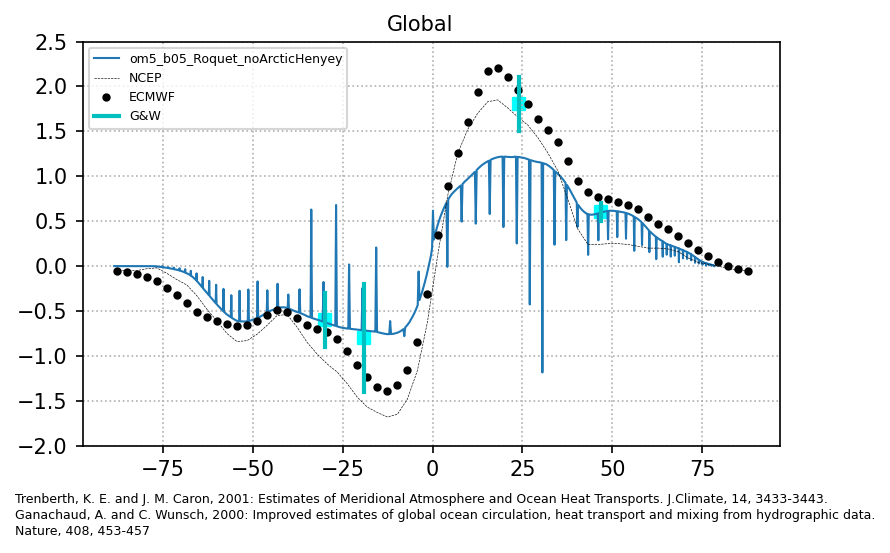

In [14]:
fig = plt.figure(figsize=(6, 3.5), dpi=150)
ax = plt.subplot(1, 1, 1)
for n, exp in enumerate(experiments):
    result = gbl_results[n]
    ax.plot(result.lat, result.values, linewidth=1.0, label=exp["expName"])
ax.plot(yobs, NCEP_Global, "k--", linewidth=0.3, label="NCEP")
ax.plot(yobs, ECMWF_Global, "k.", linewidth=0.3, label="ECMWF")
GW.gbl.annotate(ax)
#ax.set_xlim(-30, 80)
ax.set_ylim(-2, 2.5)
plt.grid(True, linestyle=":")
plt.legend(fontsize=6)

# Annotations
_ = fig.text(
    0.05,
    0.00,
    r"Trenberth, K. E. and J. M. Caron, 2001: Estimates of Meridional Atmosphere and Ocean Heat Transports. J.Climate, 14, 3433-3443.",
    fontsize=6,
)
_ = fig.text(
    0.05,
    -0.03,
    r"Ganachaud, A. and C. Wunsch, 2000: Improved estimates of global ocean circulation, heat transport and mixing from hydrographic data.",
    fontsize=6,
)
_ = fig.text(0.05, -0.06, r"Nature, 408, 453-457", fontsize=6)
_ = fig.text(0.5, 0.9, "Global", ha="center", fontsize=10)

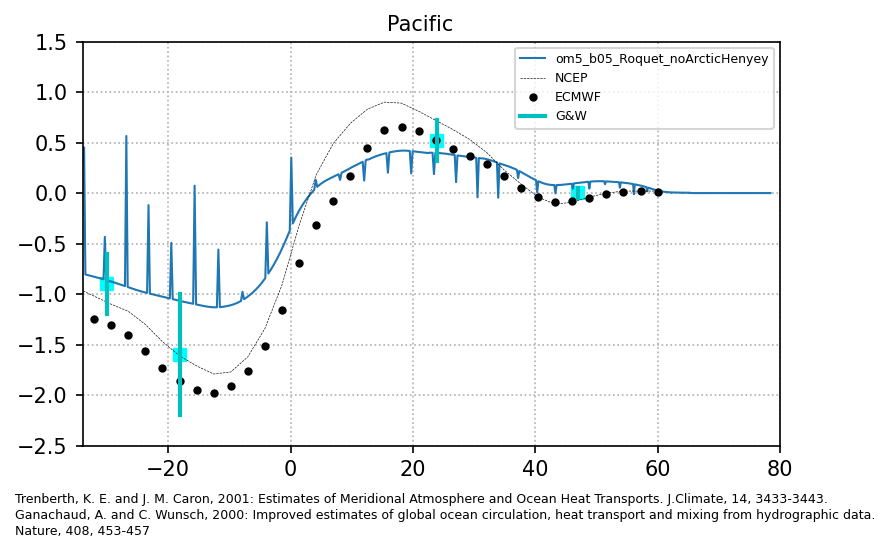

In [15]:
fig = plt.figure(figsize=(6, 3.5), dpi=150)
ax = plt.subplot(1, 1, 1)
for n, exp in enumerate(experiments):
    result = pac_results[n]
    ax.plot(result.lat, result.values, linewidth=1.0, label=exp["expName"])
ax.plot(yobs, NCEP_IndoPac, "k--", linewidth=0.3, label="NCEP")
ax.plot(yobs, ECMWF_IndoPac, "k.", linewidth=0.3, label="ECMWF")
GW.indpac.annotate(ax)
ax.set_xlim(-34, 80)
ax.set_ylim(-2.5, 1.5)
plt.grid(True, linestyle=":")
plt.legend(fontsize=6)

# Annotations
_ = fig.text(
    0.05,
    0.00,
    r"Trenberth, K. E. and J. M. Caron, 2001: Estimates of Meridional Atmosphere and Ocean Heat Transports. J.Climate, 14, 3433-3443.",
    fontsize=6,
)
_ = fig.text(
    0.05,
    -0.03,
    r"Ganachaud, A. and C. Wunsch, 2000: Improved estimates of global ocean circulation, heat transport and mixing from hydrographic data.",
    fontsize=6,
)
_ = fig.text(0.05, -0.06, r"Nature, 408, 453-457", fontsize=6)
_ = fig.text(0.5, 0.9, "Pacific", ha="center", fontsize=10)

### Write Stats to a File

In [16]:
if not "DORA_EXECUTE" in os.environ.keys():
    stats_dict = {
        "metadata": {
            "created": datetime.datetime.now().isoformat(), 
            "starttime": start, 
            "endtime": end,
        },
        "results": {},
    }
    
    for x,exp in enumerate(experiments):
        stats_dict["results"][exp["expName"]] = all_stats[x]
    
    import yaml
    yml = yaml.dump(stats_dict)
    with open('htrans_stats.yaml', 'w') as file:
        file.write(yml)
    file.close()
    print(yml)

metadata:
  created: '2024-09-21T12:33:00.477412'
  endtime: 9999
  starttime: 1
results:
  om5_b05_Roquet_noArcticHenyey:
    atlantic:
      max: 0.81
      max_lat: 23.21
    global:
      max: 1.22
      max_lat: 19.49
      min: -1.18
      min_lat: 30.56
    indopac:
      max: 0.56
      max_lat: -26.84
      min: -1.13
      min_lat: -1.13

